In [1]:
import tensorflow as tf

In [2]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
import numpy as np
from IPython.display import Image
from tensorflow.keras.optimizers import Adam


In [3]:
mobile = keras.applications.mobilenet.MobileNet()
def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    # return img_array_expanded_dims #without keras preprocess
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

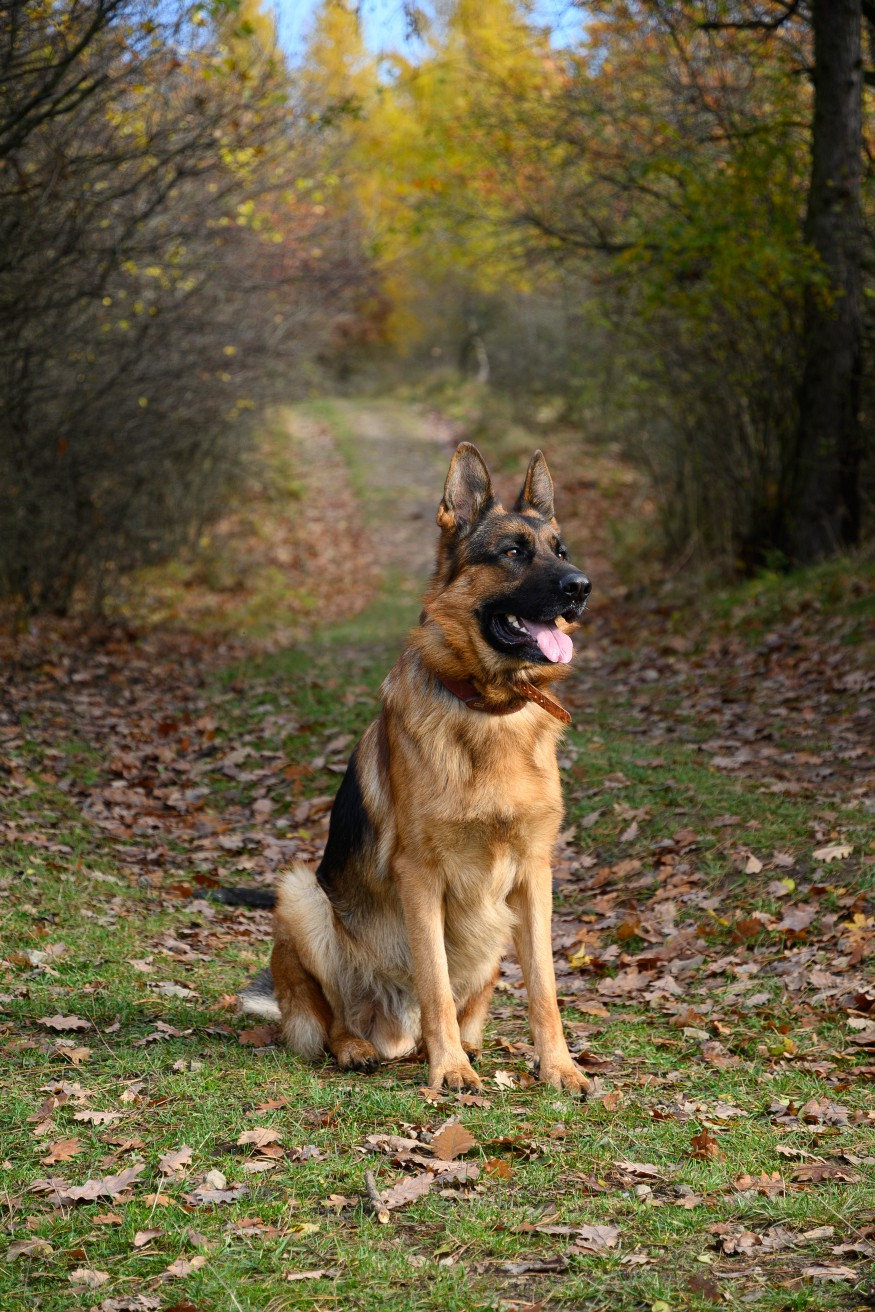

In [4]:
Image(filename='../data/gs.jpg')  #upload the gs.jpg in current dir


In [4]:

preprocessed_image = prepare_image('../data/gs.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

[[('n02106662', 'German_shepherd', 0.8954074),
  ('n02105162', 'malinois', 0.06813177),
  ('n02111129', 'Leonberg', 0.021129135),
  ('n02091467', 'Norwegian_elkhound', 0.003176625),
  ('n02114367', 'timber_wolf', 0.0028339573)]]

In [ ]:
mobile.save("model1.h5")

In [ ]:
# print(help(tf.lite.TFLiteConverter))

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(mobile)

In [ ]:
tfliteModel = converter.convert()

In [ ]:
open ("model1.tflite" , "wb") .write(tfliteModel)

In [ ]:
!mv model1.tflite ./drive/MyDrive/model1.tflite

In [6]:
def toTfliet(model, filename):
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  tfliteModel = converter.convert()
  open (f"{filename}.tflite" , "wb") .write(tfliteModel)

In [ ]:
# !unzip drive/MyDrive/DogCatNew/archive.zip 
# !unzip drive/MyDrive/catdog.zip 

In [15]:
!ls drive/MyDrive/DogCatNew/

'ls' is not recognized as an internal or external command,
operable program or batch file.


# Transfer learning

In [4]:
base_model = MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x) 
x = Dense(64, activation='relu')(x) 
preds = Dense(2, activation='softmax')(x) #final layer with softmax activation
model = Model(inputs=base_model.input,outputs=preds)

In [5]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, None, None, 32)    0     

In [17]:
train_datagen = ImageDataGenerator(preprocessing_function=None) #included in our dependencies
# path_to_dataset = "../data/dogcat/training_set/training_set/"
path_to_dataset = "../data/hand2/"

train_generator = train_datagen.flow_from_directory(path_to_dataset,
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                #  batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 193 images belonging to 2 classes.


In [18]:
step_size_train = train_generator.n // train_generator.batch_size
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=3)

C:\Users\user\anaconda3\envs\deeplearning\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
6/6 [==============================] - 12s 2s/step - loss: 0.1517 - accuracy: 0.9317
Epoch 2/3
6/6 [==============================] - 12s 2s/step - loss: 0.0615 - accuracy: 0.9938
Epoch 3/3
6/6 [==============================] - 14s 2s/step - loss: 0.0051 - accuracy: 0.9948


In [17]:
model.save("../models/modelhandsacc100v2.h5")

In [9]:
dog_cat_model = tf.keras.models.load_model("../models/modelhandsacc100.h5")
dog_cat_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, None, None, 32)    0   

In [ ]:
toTfliet(model, "model2acc")

INFO:tensorflow:Assets written to: /tmp/tmprk2tbby7/assets


In [22]:
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


handimgtest = '../data/hand2/hand/WIN_20211103_20_56_52_Pro.jpg'
nohandiogtest = '../data/hand2/nohand/WIN_20211103_20_55_20_Pro (2).jpg'

img_path = [handimgtest, nohandiogtest]
new_image = load_image(img_path[1])
new_image

pred = model.predict(new_image)
# pred = dog_cat_model.predict(new_image)
pred

array([[1.226268e-08, 1.000000e+00]], dtype=float32)